# 📊 XGBoost Regression with California Housing Dataset
This notebook demonstrates a complete machine learning workflow for regression using XGBoost algorithm on the California Housing dataset. The project includes data loading from local files, preprocessing, exploratory data analysis (EDA), model training with hyperparameter tuning, comprehensive evaluation with visualizations, and insights into model performance for predicting house prices.

In [6]:
# Cell 1: Import libraries and set global configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib

warnings.filterwarnings('ignore')

# Jupyter visualization settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

In [7]:
# Cell 2: Load California Housing dataset from local files
# Read the data file
data_path = '../../data/CaliforniaHousing/cal_housing.data'
domain_path = '../../data/CaliforniaHousing/cal_housing.domain'

# Load the raw data
column_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

df = pd.read_csv(data_path, header=None, names=column_names)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Read domain information
if os.path.exists(domain_path):
    with open(domain_path, 'r') as f:
        domain_info = f.read()
    print(f"\nDomain information:\n{domain_info}")

Dataset shape: (20640, 9)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Data types:
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
dtype: object

First 5 rows of the dataset:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income

In [8]:
# Cell 3: Data preprocessing
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Basic statistics
print(f"\nBasic statistics:")
print(df.describe())

# Handle missing values if any (fill with median)
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

# Create additional features
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# Separate features and target
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Remove outliers (values beyond 3 standard deviations)
z_scores = np.abs((y - y.mean()) / y.std())
X = X[z_scores < 3]
y = y[z_scores < 3]

print(f"\nAfter outlier removal - Dataset shape: {X.shape}")
print(f"Target variable range: ${y.min():,.0f} - ${y.max():,.0f}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Missing values per column:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Basic statistics:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.00

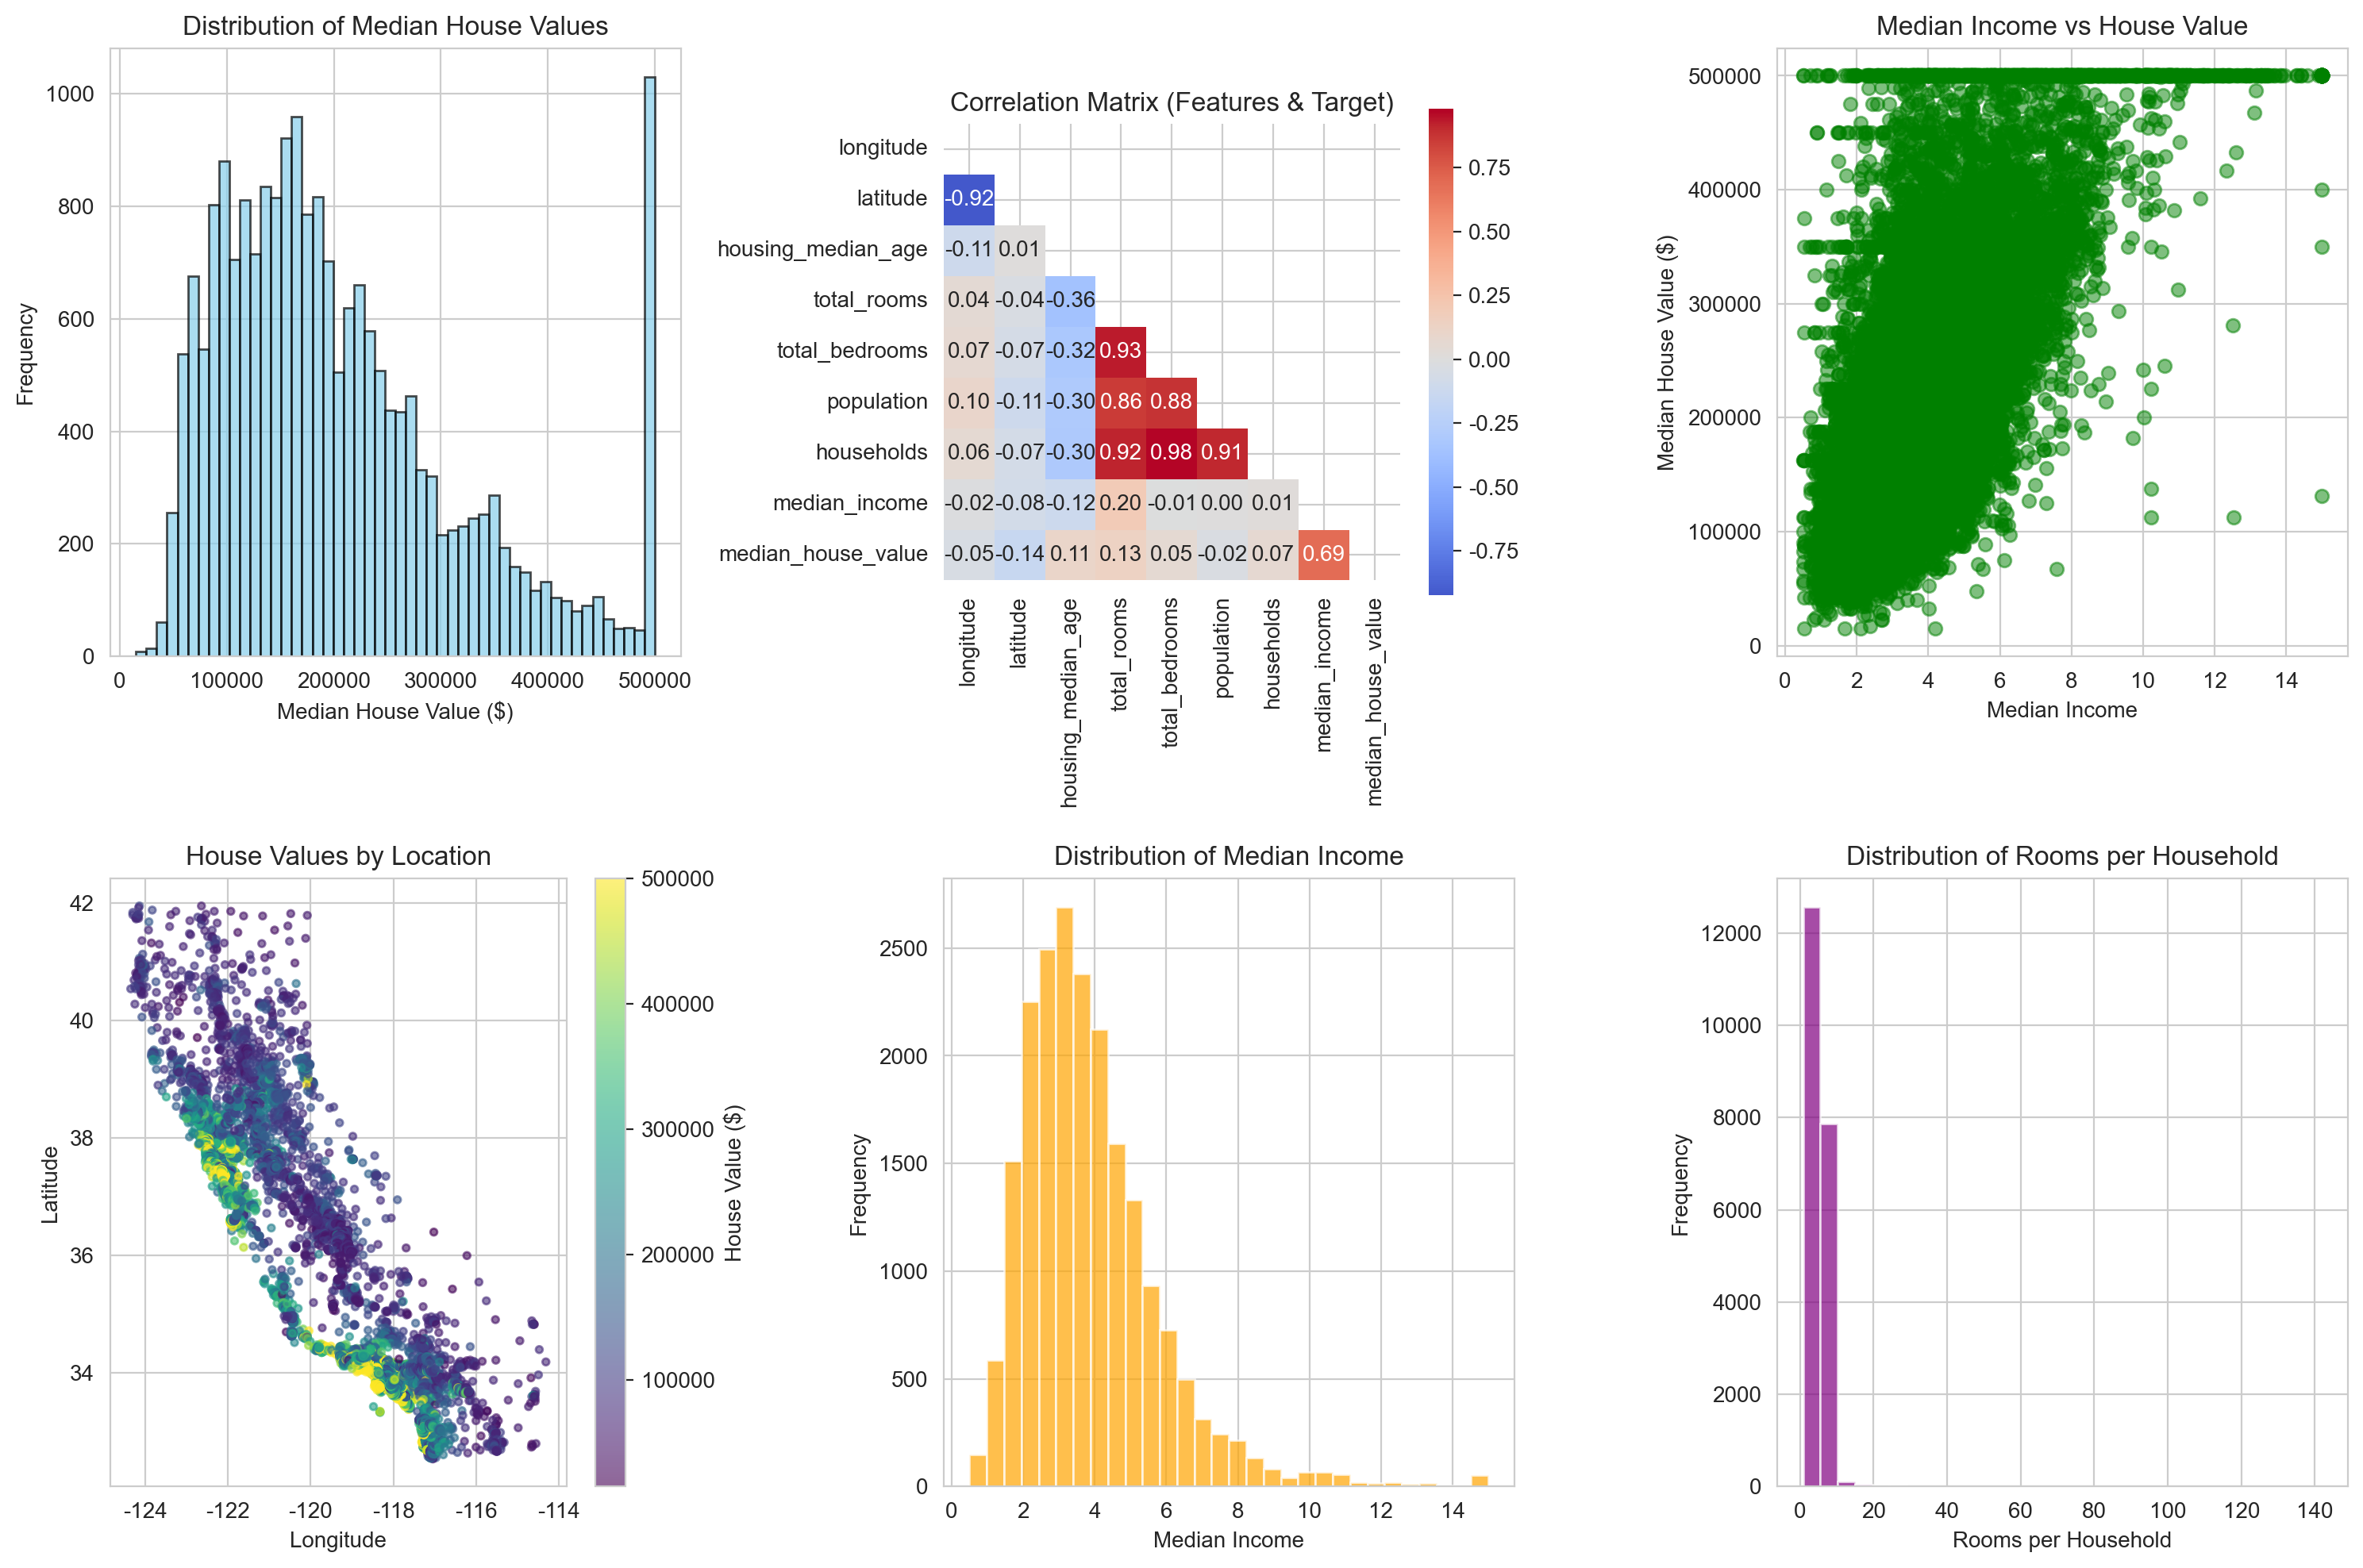

In [22]:
# Cell 4: Exploratory Data Analysis
# Visualize target variable distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(y, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Median House Values')
plt.xlabel('Median House Value ($)')
plt.ylabel('Frequency')

# Correlation heatmap
plt.subplot(2, 3, 2)
# Select a subset of features for better visualization
subset_features = X.columns[:8]  # First 8 features
corr_matrix = pd.concat([X[subset_features], y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix (Features & Target)')

# Scatter plot: median income vs house value
plt.subplot(2, 3, 3)
plt.scatter(df['median_income'], df['median_house_value'], alpha=0.5, color='green')
plt.xlabel('Median Income')
plt.ylabel('Median House Value ($)')
plt.title('Median Income vs House Value')

# Geographic visualization (latitude vs longitude with house values)
plt.subplot(2, 3, 4)
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['median_house_value'],
                     cmap='viridis', alpha=0.6, s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House Values by Location')
plt.colorbar(scatter, label='House Value ($)')

# Feature distributions
plt.subplot(2, 3, 5)
df['median_income'].hist(bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Median Income')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

# Rooms per household
plt.subplot(2, 3, 6)
df['rooms_per_household'].hist(bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Rooms per Household')
plt.xlabel('Rooms per Household')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
# 测试GPU模型是否正常工作
try:
    print("Testing GPU model...")
    test_model = xgb.XGBRegressor(
        tree_method='gpu_hist',
        device='cuda',
        n_estimators=50,
        max_depth=3,
        random_state=42
    )

    # 使用小样本测试
    test_X = X_train_scaled[:100]  # 使用前100个样本
    test_y = y_train[:100]

    test_model.fit(test_X, test_y)
    print("GPU model training successful!")

    # 现在使用完整的参数网格
    xgb_model = xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        tree_method='gpu_hist',
        device='cuda'
    )

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.1, 0.2]
    }

    print("Performing hyperparameter tuning with GPU acceleration...")
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error',
                              n_jobs=1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    best_xgb_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score (MSE): {-grid_search.best_score_:.4f}")

    best_xgb_model.fit(X_train_scaled, y_train)
    y_pred = best_xgb_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE: ${rmse:,.2f}")
    print(f"Test MAE: ${mae:,.2f}")
    print(f"Test R²: {r2:.4f}")

except Exception as e:
    print(f"GPU training failed: {e}")
    print("Falling back to CPU optimization...")

    # 回退到CPU优化版本
    xgb_model = xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    )

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.1, 0.2]
    }

    print("Performing hyperparameter tuning (CPU optimized)...")
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error',
                              n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    best_xgb_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score (MSE): {-grid_search.best_score_:.4f}")

    best_xgb_model.fit(X_train_scaled, y_train)
    y_pred = best_xgb_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE: ${rmse:,.2f}")
    print(f"Test MAE: ${mae:,.2f}")
    print(f"Test R²: {r2:.4f}")

Testing GPU model...
GPU training failed: Invalid Input: 'gpu_hist', valid values are: {'approx', 'auto', 'exact', 'hist'}
Falling back to CPU optimization...
Performing hyperparameter tuning (CPU optimized)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score (MSE): 2199510379.2421
Test RMSE: $45,914.90
Test MAE: $30,256.93
Test R²: 0.8391


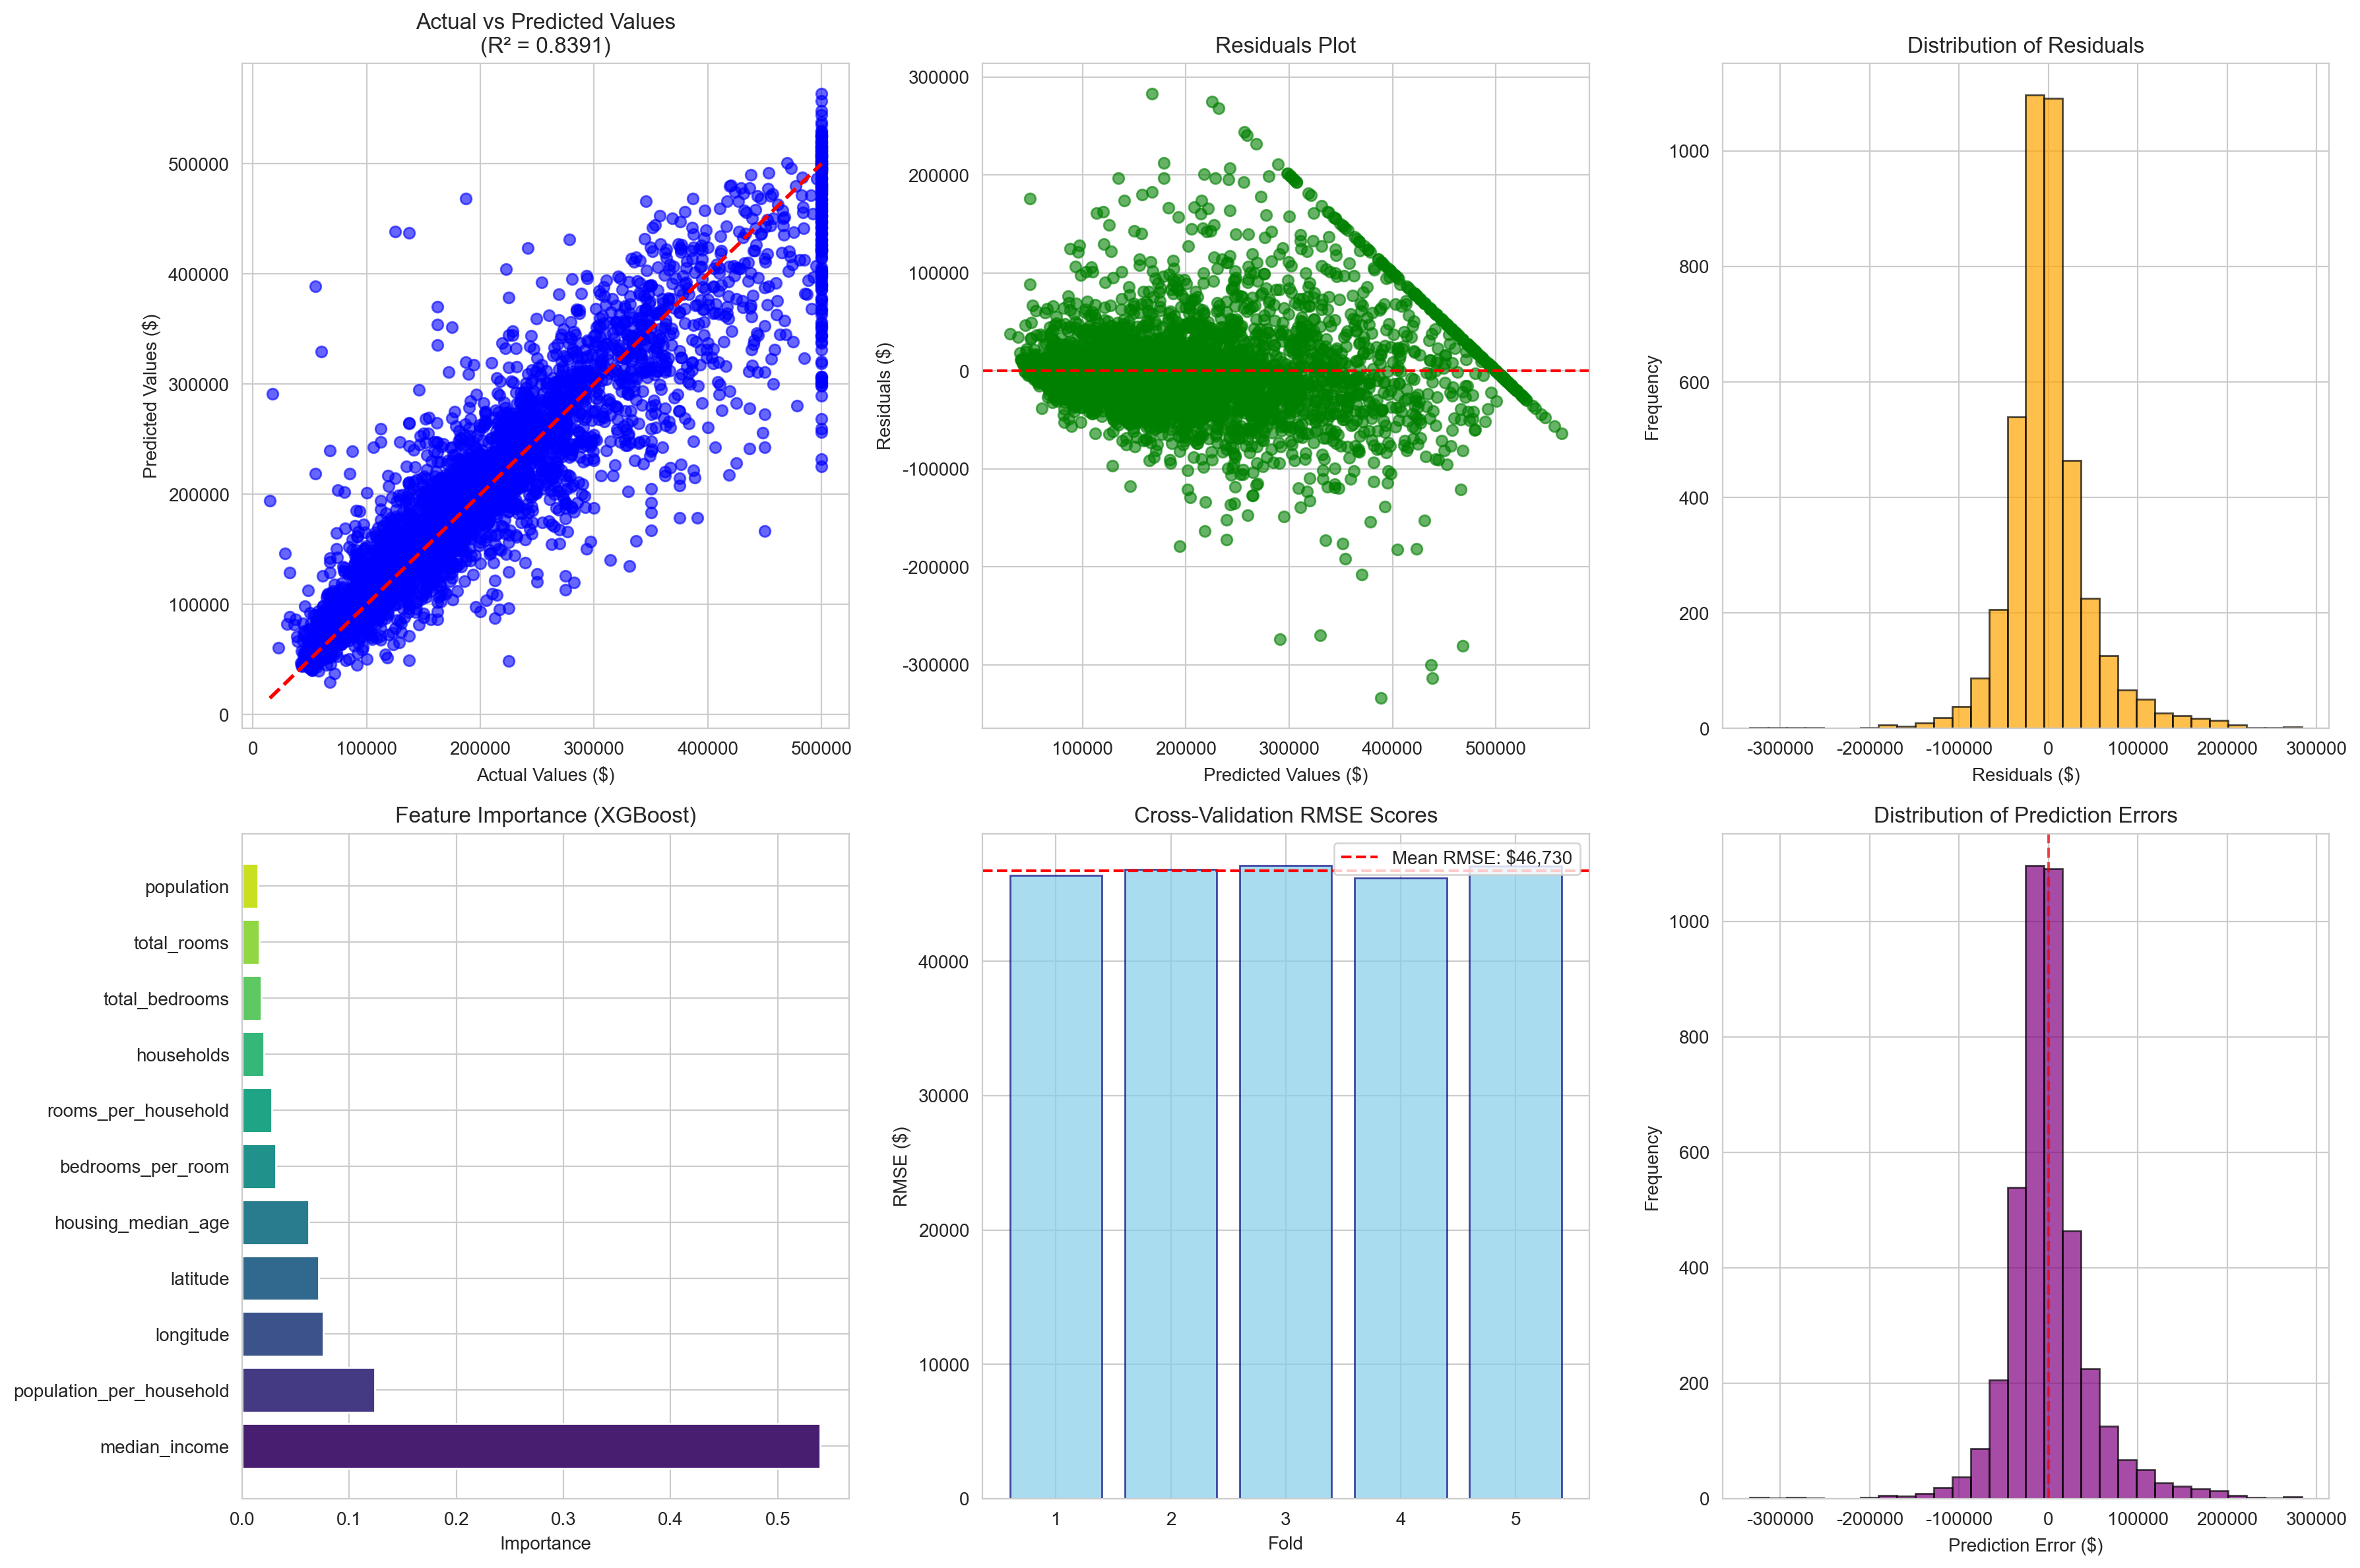

Model Evaluation Metrics:
RMSE: $45,914.90
MAE: $30,256.93
R² Score: 0.8391
Mean Absolute Percentage Error: 17.44%


In [16]:
# Cell 6: Visualization of results
# Results visualization
plt.figure(figsize=(18, 12))

# Actual vs Predicted values
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values ($)')
plt.ylabel('Predicted Values ($)')
plt.title(f'Actual vs Predicted Values\n(R² = {r2:.4f})')

# Residuals plot
plt.subplot(2, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values ($)')
plt.ylabel('Residuals ($)')
plt.title('Residuals Plot')

# Residuals histogram
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

# Feature importance
plt.subplot(2, 3, 4)
feature_importance = best_xgb_model.feature_importances_
indices = np.argsort(feature_importance)[::-1]

plt.barh(range(len(feature_importance)), feature_importance[indices],
         color=sns.color_palette('viridis', len(feature_importance)))
plt.yticks(range(len(feature_importance)), [X.columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')

# Cross-validation scores
plt.subplot(2, 3, 5)
cv_scores = cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=5,
                           scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
plt.bar(range(1, len(cv_rmse_scores)+1), cv_rmse_scores, color='skyblue', edgecolor='navy', alpha=0.7)
plt.axhline(y=cv_rmse_scores.mean(), color='red', linestyle='--',
            label=f'Mean RMSE: ${cv_rmse_scores.mean():,.0f}')
plt.title('Cross-Validation RMSE Scores')
plt.xlabel('Fold')
plt.ylabel('RMSE ($)')
plt.legend()

# Prediction error distribution
plt.subplot(2, 3, 6)
plt.hist(y_test - y_pred, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print detailed evaluation metrics
print("Model Evaluation Metrics:")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")

Model Performance by House Value Range:
                       error           relative_error actual
                        mean       std           mean  count
median_house_value                                          
Very Low            19829.95  25739.11           0.29    904
Low                 24074.57  26164.17           0.16   1589
Medium              32254.58  29669.26           0.13    915
High                46169.08  39799.14           0.13    382
Very High           63817.50  59423.18           0.13    338

Top 5 Most Important Features:
median_income: 0.5397
population_per_household: 0.1237
longitude: 0.0759
latitude: 0.0711
housing_median_age: 0.0621

XGBoost Model Parameters:
N Estimators: 200
Max Depth: 5
Learning Rate: 0.2
Subsample: None
Colsample by Tree: None


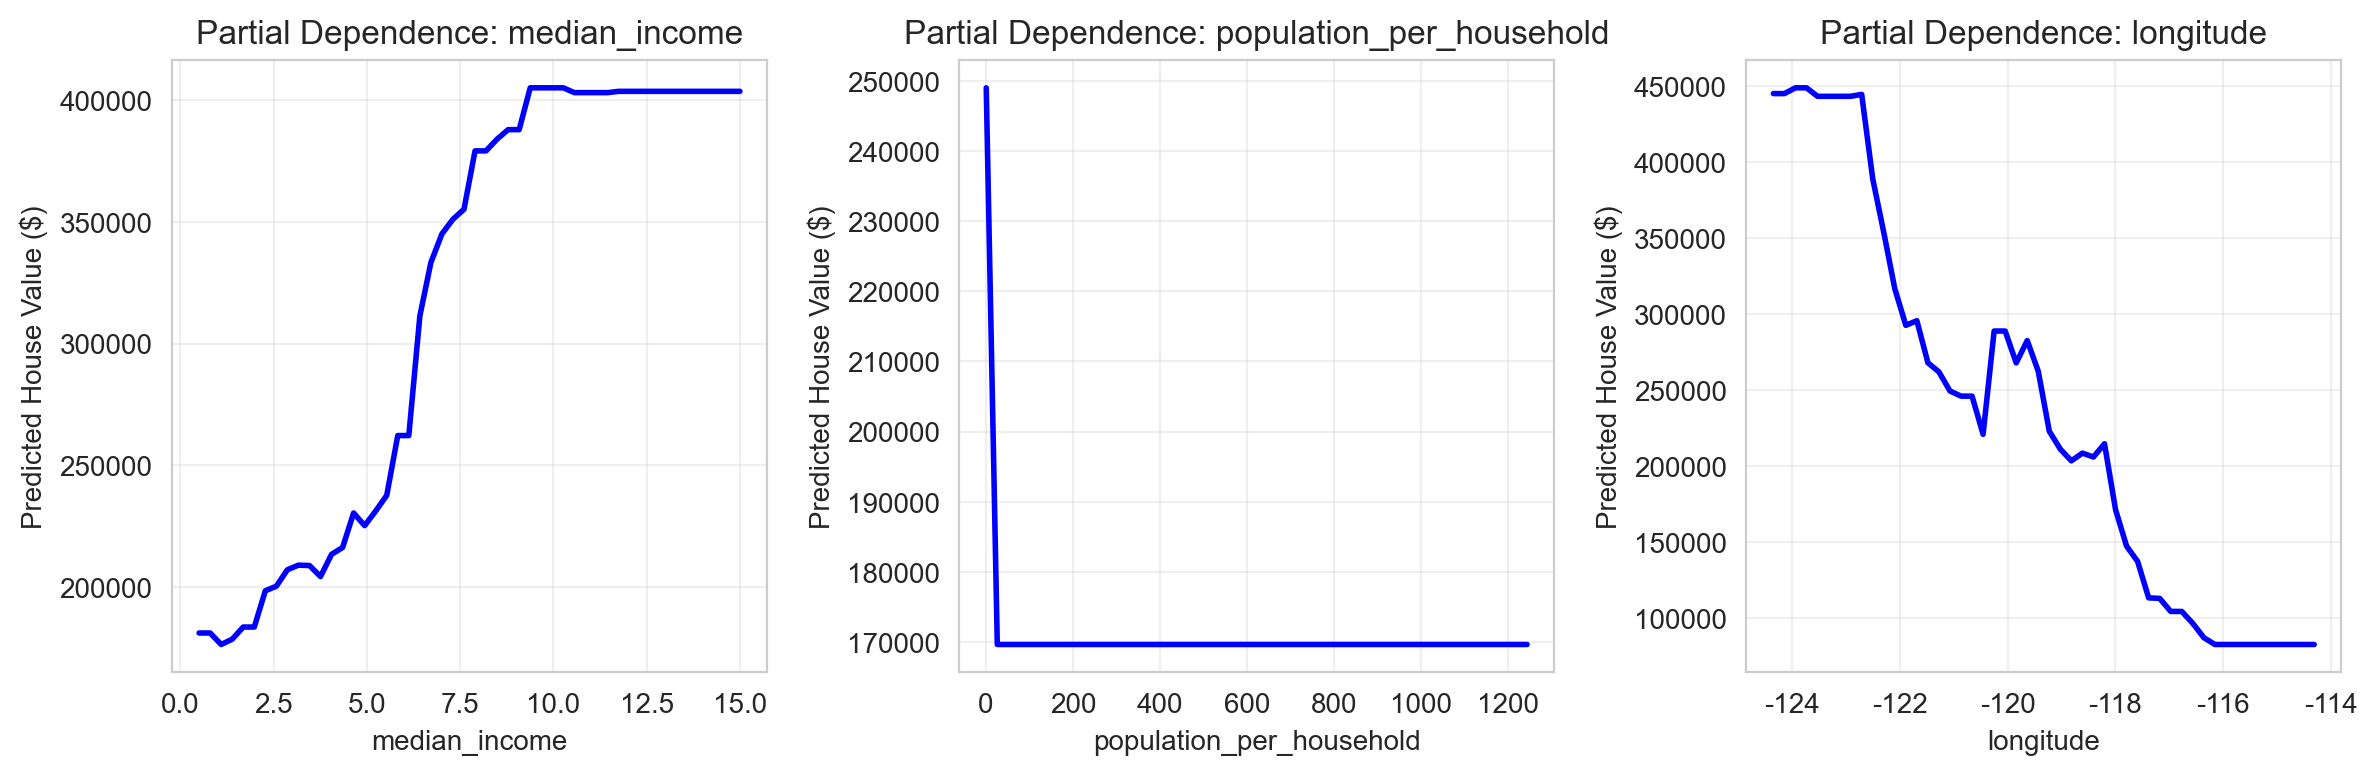

In [25]:
# Cell 7: Model analysis and insights
# Analyze prediction performance across different value ranges
df_test = X_test.copy()
df_test['actual'] = y_test
df_test['predicted'] = y_pred
df_test['error'] = np.abs(y_test - y_pred)
df_test['relative_error'] = df_test['error'] / y_test

# Performance by house value ranges
value_ranges = pd.cut(y_test, bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
performance_by_range = df_test.groupby(value_ranges).agg({
    'error': ['mean', 'std'],
    'relative_error': 'mean',
    'actual': 'count'
}).round(2)

print("Model Performance by House Value Range:")
print(performance_by_range)

# Feature importance analysis
print(f"\nTop 5 Most Important Features:")
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, row in feature_importance_df.head().iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Learning curves (if available)
print(f"\nXGBoost Model Parameters:")
print(f"N Estimators: {best_xgb_model.n_estimators}")
print(f"Max Depth: {best_xgb_model.max_depth}")
print(f"Learning Rate: {best_xgb_model.learning_rate}")
print(f"Subsample: {best_xgb_model.subsample}")
print(f"Colsample by Tree: {best_xgb_model.colsample_bytree}")

# Partial dependence plots for top features
top_features = feature_importance_df.head(3)['feature'].tolist()
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, feature in enumerate(top_features):
    # Create a simple partial dependence by varying one feature while keeping others constant
    feature_values = np.linspace(X[feature].min(), X[feature].max(), 50)
    predictions = []

    # Use median values for other features
    other_features_median = X.median()

    for val in feature_values:
        temp_X = other_features_median.copy()
        temp_X[feature] = val
        temp_X = scaler.transform([temp_X])
        pred = best_xgb_model.predict(temp_X)[0]
        predictions.append(pred)

    axes[i].plot(feature_values, predictions, color='blue', linewidth=2)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Predicted House Value ($)')
    axes[i].set_title(f'Partial Dependence: {feature}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Cell 8: Model performance summary and insights
# Summary statistics
print("Model Performance Summary:")
print(f"Test RMSE: ${rmse:,.2f}")
print(f"Test MAE: ${mae:,.2f}")
print(f"Test R² Score: {r2:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-validation RMSE: ${cv_rmse_scores.mean():,.2f} (+/- ${cv_rmse_scores.std() * 2:,.2f})")

# Prediction accuracy analysis
error_percentiles = np.percentile(np.abs(y_test - y_pred), [25, 50, 75, 90, 95])
print(f"\nPrediction Error Percentiles:")
print(f"25th percentile: ${error_percentiles[0]:,.2f}")
print(f"50th percentile (median): ${error_percentiles[1]:,.2f}")
print(f"75th percentile: ${error_percentiles[2]:,.2f}")
print(f"90th percentile: ${error_percentiles[3]:,.2f}")
print(f"95th percentile: ${error_percentiles[4]:,.2f}")

# Feature engineering effectiveness
print(f"\nFeature Engineering Results:")
print(f"Original features: {len(X.columns) - 3}")  # Subtract 3 engineered features
print(f"Total features after engineering: {len(X.columns)}")
print(f"Engineered features: rooms_per_household, bedrooms_per_room, population_per_household")

# Model complexity analysis
print(f"\nModel Complexity:")
print(f"Number of trees: {best_xgb_model.n_estimators}")
print(f"Max depth of trees: {best_xgb_model.max_depth}")
print(f"Number of features: {X.shape[1]}")

# Potential model improvements
print(f"\nModel Improvement Suggestions:")
print(f"• Current R² of {r2:.4f} indicates moderate to good fit")
print(f"• Consider adding polynomial features for non-linear relationships")
print(f"• Try ensemble methods combining XGBoost with other algorithms")
print(f"• Collect additional features like proximity to schools, crime rates, etc.")
print(f"• Address the higher errors in high-value property predictions")

Model Performance Summary:
Test RMSE: $45,914.90
Test MAE: $30,256.93
Test R² Score: 0.8391
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Cross-validation RMSE: $46,730.44 (+/- $737.17)

Prediction Error Percentiles:
25th percentile: $8,882.59
50th percentile (median): $19,398.16
75th percentile: $38,869.43
90th percentile: $68,266.78
95th percentile: $97,212.13

Feature Engineering Results:
Original features: 8
Total features after engineering: 11
Engineered features: rooms_per_household, bedrooms_per_room, population_per_household

Model Complexity:
Number of trees: 200
Max depth of trees: 5
Number of features: 11

Model Improvement Suggestions:
• Current R² of 0.8391 indicates moderate to good fit
• Consider adding polynomial features for non-linear relationships
• Try ensemble methods combining XGBoost with other algorithms
• Collect additional features like proximity to schools, crime rates, etc.
• Address the higher errors in high-value property pre